Clustering and Community Detection Methods Using NetworkX


## Background
Real-world networks reveal clustering behaviour, in the formation of communities/clusters/partitions, in the graph structure. So when studying networks, their structure and function, it is crucial to identify these communities. In this project, different structures (including **cliques** and **connected components**) with a strong focus on clustering and community detection, will be identified. 
<br> 
<br> In particular, we wanted to explore two general methods, and three sub-methods:

1. Divisive Method
    - Girvan-Newman algorithm using _edge betweenness_ 
2. Agglomerative Method
    - Ravasz (hierarchical clustering) algorithm using _distance matrix_ 
    - Louvain method using _modularity_ 


*import libraries*

In [1]:
## For Network Analysis and Visualization
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import operator

## For Hierarchical Clustering
from scipy.cluster import hierarchy
from scipy.spatial import distance

## For Community Detection (Louvain Method)
import community


In [2]:
print(nx.__version__)

2.6.3


## Load the Network
Here, [Wayne Zachary's](https://www.journals.uchicago.edu/doi/10.1086/jar.33.4.3629752) karate club network $K$ is used to illustrate some concepts on network structures. The network captures 34 members of a karate club from 1970 to 1972, documenting links between pairs of members who interacted outside the club. It is a popular example of how community structure is identified in networks.

In [3]:
K = nx.karate_club_graph()

## Network Structure and Properties

1. Clique
2. Connected Components
3. Edge Betweenness 

In [4]:
print("Number of nodes: ", K.size())
print("Number of edges: ", K.order())

Number of nodes:  78
Number of edges:  34


In [5]:
# original layout
pos = nx.fruchterman_reingold_layout(K);

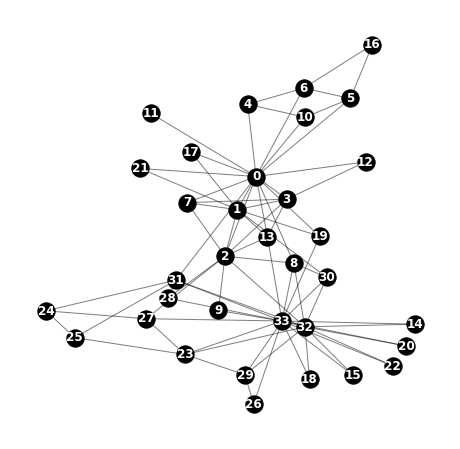

In [6]:
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(K, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(K, pos, alpha=0.500);
nx.draw_networkx_labels(K, pos, font_color="white");
plt.show();

### Real-world partition

During Zachary's study, a conflict arose between the administrator 'John A' and instructor 'Mr Hi' (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi, while members from the other part found a new instructor or gave up karate. 

In [7]:
# communities defined
mrhi = [0,1,2,3,4,5,6,7,8,10,11,12,13,16,17,19,21]
johna = [9,14,15,18,20,22,23,24,25,26,27,28,29,30,31,32,33]

for mem in K.nodes():
    if mem in mrhi:
        K.nodes[mem]["group"] = "mrhi"
    else:
        K.nodes[mem]["group"] = "johna"

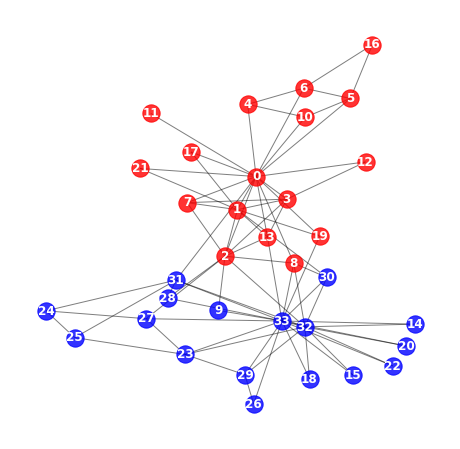

In [8]:
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(K,pos,
                       nodelist=mrhi,
                       node_color='r',
                       node_size=300,
                   alpha=0.8);
nx.draw_networkx_nodes(K,pos,
                       nodelist=johna,
                       node_color='b',
                       node_size=300,
                   alpha=0.8);
nx.draw_networkx_edges(K, pos, alpha=0.5);
nx.draw_networkx_labels(K, pos, font_color="white");


### Cliques
Cliques are **complete subgraphs**; that is, subgraphs are where the nodes are all _directly_ connected to each other. For example, using the Karate Club network $K$, the cliques are listed below. Note that any two connected nodes in an undirected network are considered to form a **clique**.

In [9]:
print(list(nx.find_cliques(K)))

[[0, 1, 17], [0, 1, 2, 3, 13], [0, 1, 2, 3, 7], [0, 1, 19], [0, 1, 21], [0, 4, 10], [0, 4, 6], [0, 5, 10], [0, 5, 6], [0, 8, 2], [0, 11], [0, 12, 3], [0, 31], [1, 30], [2, 32, 8], [2, 9], [2, 27], [2, 28], [5, 16, 6], [33, 32, 8, 30], [33, 32, 14], [33, 32, 15], [33, 32, 18], [33, 32, 20], [33, 32, 22], [33, 32, 23, 29], [33, 32, 31], [33, 9], [33, 13], [33, 19], [33, 26, 29], [33, 27, 23], [33, 28, 31], [24, 25, 31], [24, 27], [25, 23]]


## Divisive Method: The Girvan-Newman Algorithm
The Girvan–Newman algorithm detects communities by progressively removing edges from the original network. The connected components of the remaining network are the communities. Instead of trying to construct a measure that tells us which edges are the most central to communities, the Girvan–Newman algorithm focuses on edges that are most likely "between" communities.

The algorithm extends this definition to the case of edges, defining the **edge betweenness** of an edge as the number of shortest paths between pairs of nodes that run along it. If there is more than one shortest path between a pair of nodes, each path is assigned equal weight such that the total weight of all of the paths is equal to unity.

### Edge Betweenness
The **betweenness** of an edge $e$ is the fraction of shortest-paths that course through it. 

$$c_B(e)=\sum _{i,j \in V}\frac{\sigma (i,j)|e}{\sigma (i,j)},$$

where $\sigma(i,j)$ is the total number of shortest paths and $\sigma (i,j)|e$ is the number of shortest paths that pass through edge $e$. In `networkx`, the function is `edge_betweenness_centrality(G)`. 


In [10]:
#order the dictionary by value, which is the edge betweeness of two nodes
ebet = nx.edge_betweenness_centrality(K)
sorted_ebet = sorted(ebet.items(), key=operator.itemgetter(1), reverse=True)
sorted_ebet[0:5]

[((0, 31), 0.1272599949070537),
 ((0, 6), 0.07813428401663695),
 ((0, 5), 0.07813428401663694),
 ((0, 2), 0.0777876807288572),
 ((0, 8), 0.07423959482783014)]

First, the betweenness of all existing edges in the network is calculated. Then, iteratively, remove edges with the highest edge betweenness. So node 0 and node 31 have the highest edge betweenness scores, and might therefore be thought to be the most central people in this karate club.

In [11]:
# first make a copy of the karate club network K. 
K2 = K.copy()

def remove_top_ebet(K2):
    ebet = nx.edge_betweenness_centrality(K2)
    sorted_ebet = sorted(ebet.items(), key=operator.itemgetter(1), reverse=True)
    edge_to_remove = sorted_ebet[0]
    K2.remove_edge(*edge_to_remove[0])
    return K2


We perform $i=10$ iterations of edge removal.

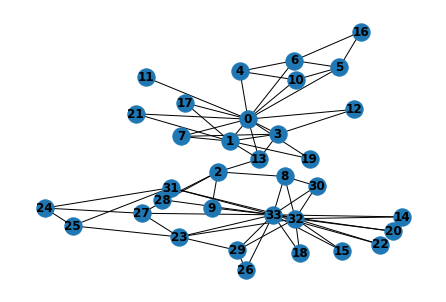

In [12]:
for i in range(10):
    K2=remove_top_ebet(K2)
    
nx.draw(K2, pos)
nx.draw_networkx_labels(K2, pos)
plt.show()

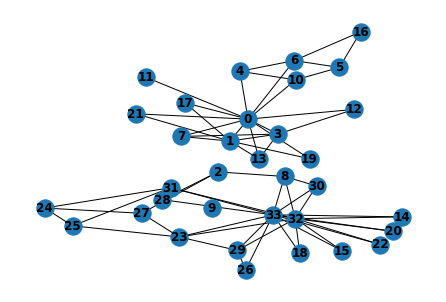

In [13]:
# We perform i=5 iterations of edge removal.
for i in range(5):
    K2=remove_top_ebet(K2)
    
nx.draw(K2, pos)
nx.draw_networkx_labels(K2, pos)
plt.show()

The algorithm for finding "communities" based on edge betweenness removal was presented by Girvan-Newmann in their [2002 PNAS paper](http://www.pnas.org/content/99/12/7821). Based on the method implemented, the algorithm is classified as a _divisive procedure_, ie., it tries to find an optimal way of cutting the graph into two pieces, and then it does the same on the following pieces (as opposed to _agglomerative procedure_). 

A code snippet taken [here](http://www-rohan.sdsu.edu/~gawron/python_for_ss/course_core/book_draft/Social_Networks/Networkx.html) is shown below. <img src="./figs/girvan-newman.png">

### Connected Components

**Connected components** are subgraphs where all the nodes are connected to each via a path. Unlike **cliques**, they do not have to be _directly_ connected. And the **Giant Component** refers to the network's largest component.

In [14]:
print("Number of components: ", len(list(nx.connected_components(K2))),"\n")
print(list(nx.connected_components(K2)))

Number of components:  3 

[{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {9}]


In [15]:
# same result as above
K3 = (K2.subgraph(c) for c in nx.connected_components(K2))
for k in K3:
    print(k)
    print(list(k))

Graph named "Zachary's Karate Club" with 15 nodes and 27 edges
[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Graph named "Zachary's Karate Club" with 18 nodes and 36 edges
[2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Graph named "Zachary's Karate Club" with 1 nodes and 0 edges
[9]


There are three principal components with the network. The partition is reasonable compared with the actual division of the club members. As above, club division is most likely to be caused by some (known) leaders. If leaders change, communities will change, ie., network will be divided differently. 

## Agglomerative Method: Hierarchical Clustering
As opposed to divisive procedure, agglomerative method has the following advantages: clustering (or classification) enables dissimilarities between the objects to be grouped together. 

We start with a **distance matrix** $D$, which is a matrix that provides the distance between two nodes $i$ and $j$ in network $G$. Using $D$, we then perform [hierarchical clustering](http://docs.scipy.org/doc/scipy-0.17.0/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy) in a recursive manner, where we group _similar_ nodes at each step. There are various ways to perform the similarity grouping using _agglomerative procedures_ such as **single**, **complete**, and **average**, to name a few. 
<br>
<br> In the example below, we implement the [average/UPGMA linkage](http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.cluster.hierarchy.average.html#scipy.cluster.hierarchy.average), which was implemented in the Ravasz Algorithm published in [Science in 2002](http://science.sciencemag.org/content/297/5586/1551). 

So here, we perform hierarchical clustering and visualize the order in which the nodes are grouped together in communities.


In [16]:
__author__ = """\n""".join(['Erika Fille Legara <legareft@ihpc.a-star.edu.sg>',
                            'Maksim Tsvetovat <maksim@tsvetovat.org',
                            'Drew Conway <drew.conway@nyu.edu>',
                            'Aric Hagberg <hagberg@lanl.gov>'])
    
'''
The original code was written by Drew Conway and Aric Hagberg and was later 
modified by Maksim Tsvetovat for his book titled “Social Network Analysis for Startups”.
EF Legara slightly modified Tsvetovat's version to address some issues 
on the ordering of keys within the path_length dictionary. Moreover,
in this code, a different agglomerative procedure is implemented.
'''

def create_hc(G, t):
    ## Set-up the distance matrix D
    labels=G.nodes()    # keep node labels
    path_length=dict(nx.all_pairs_shortest_path_length(G))
    distances=np.zeros((len(G),len(G)))   
    for u,p in path_length.items():
        for v,d in p.items():
            distances[list(G.nodes()).index(u)][list(G.nodes()).index(v)] = d
            distances[list(G.nodes()).index(v)][list(G.nodes()).index(u)] = d
            if u==v: distances[list(G.nodes()).index(u)][list(G.nodes()).index(u)]=0

    # Create hierarchical cluster (HC)
    # There are various other routines for agglomerative clustering, 
    #   but here we create the HCs using the complete/max/farthest point linkage 
    Y = distance.squareform(distances) ## the upper triangular of the distance matrix 
    Z = hierarchy.average(Y)
    
    # This partition selection (t) is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=t))
    
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        partition[p].append(labels[n])
        
    return Z, membership, partition

The classical approach to hierarchical clustering is by using a cluster validity index to select the best partition according to the criterion imposed by this index. Here, $t$=1.15.

In [17]:
Z, membership, partition = create_hc(K, t=1.15) 
partition.keys()

dict_keys([4, 1, 2, 5, 3])

In [18]:
partition.values()

dict_values([[{'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Mr. Hi', 'group': 'mrhi'}], [{'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Mr. Hi', 'group': 'mrhi'}], [{'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Mr. Hi', 'group': 'mrhi'}], [{'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Officer', 'group': 'johna'}, {'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Officer', 'group': 'johna'}, {'club': 'Officer', 'group': 'johna'}, {'club': 'Officer', 'group': 'johna'}, {'club': 'Mr. Hi', 'group': 'mrhi'}, {'club': 'Officer', 'group': 'johna'}, {'club': 'Officer', 'group': 'johna'}, {'club': 'Officer', 'group': 'johna'}, {'club': 'Officer', 'group': 'johna'}, {'club': 'Officer', 'group': 'johna'}, {'club': 'Officer', 'group': 'johna'}

In [19]:
partition = {}
i = 0
for i in range(len(membership)):
    partition[i]=membership[i]

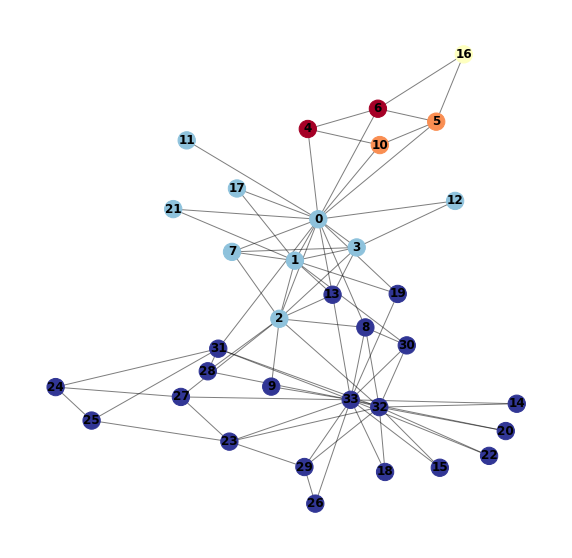

In [20]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx_nodes(K, pos, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(K, pos, alpha=0.5)
nx.draw_networkx_labels(K, pos)
plt.show()

In any cluster analysis algorithm, it is important to quantify dissimilarities between any two clusters. The above partitions are based on (maximum) _complete linkage_ analysis, because a cluster is formed when all the dissimilarities (or 'links') between pairs of nodes in the cluster are less then a particular level. 

### Dendrogram
The dendrogram allows us to visualize the order in which nodes are grouped together in the clustering process. The y-axis is a measure of dissimilarity within the clusters. Each 'fusion' is represented by a vertical line between clusters.

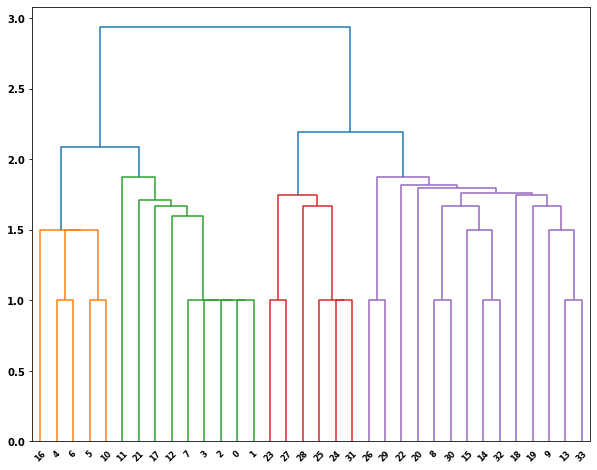

In [21]:
plt.figure(figsize=(10,8))
hierarchy.dendrogram(Z)
plt.show()

## Modularity-Based Community Detection: The Louvain Method

The **community detection algorithm** that is implemented  here is a **modularity**-based algorithm. The **modularity** $M_c$ quantifies how good a "community" or partition is, and is given by

\begin{equation}
M_c = \sum _{c=1} ^{n_c} \left[ \frac{L_c}{L} - \left (\frac{k_c}{2L} \right)^2\right]
\end{equation}

where $n_c$ is the number of communiies, $L_c$ is the number of links within the community, $k_c$ is the total degree of nodes belonging to the community, and $L$ is the total number of links in the network. The illustration below that is taken from the slide deck shows how modularity is calculated.

<img src="./figs/Modularity_Calc.png" width="75%">

The higher the network modularity is, the more optimal the partitionioning. And, if you only have a single community, $M=0$.

<img src="./figs/Modularity.png" width="75%">

Here, we implement a modularity-maximization algorithm called the Louvain algorithm. We used Zachary's karate club to find the best partitions.

In [22]:
partition = community.best_partition(K)

Redraw the network, highlighting the different communities by node color.

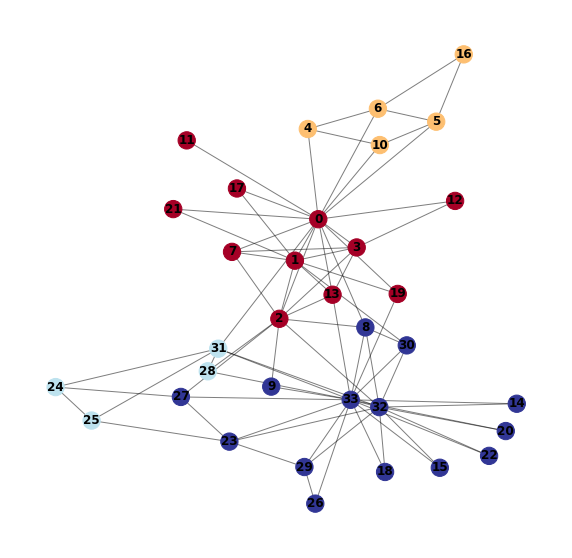

In [23]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx_nodes(K, pos, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(K, pos, alpha=0.5)
nx.draw_networkx_labels(K, pos)
plt.show()

The algorithm produces four (4) partitions. Let's compare this partition to the actual.
<br> The results were not bad at all. The dark red and light blue nodes were part of the network of 'John A', while the others were part of 'Mr Hi'. 

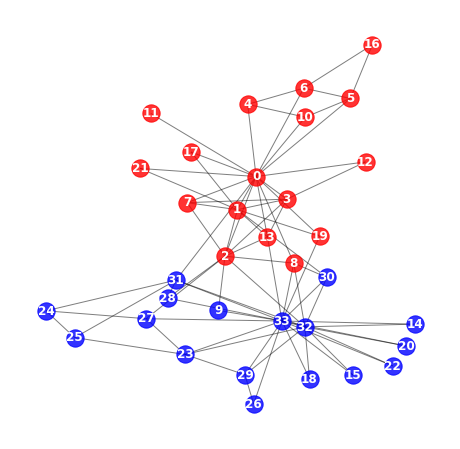

In [24]:
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(K,pos, nodelist=mrhi, node_color='r',
                       node_size=300, alpha=0.8);
nx.draw_networkx_nodes(K,pos, nodelist=johna, node_color='b', 
                       node_size=300, alpha=0.8);
nx.draw_networkx_edges(K, pos, alpha=0.5);
nx.draw_networkx_labels(K, pos, font_color="white");

## More Real-World Networks
### Sample 1: The Marvel Universe
There are two types of Marvel Universe networks that is [available on the web](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network), the Comic Network and the Hero Network. The Comic Network connects the characters to the comic issues they appeared in. On the other hand, the Hero Network represents the connections between characters as they appear in the same comic issue (weighted). Here, we look at the Hero Network.

In [25]:
import unicodecsv as csv

M = nx.Graph(name="Marvel Universe")
reader = csv.reader(open("./Module 6 Datasets/hero-network.csv", 'rb'))
for row in reader:
    M.add_edge(*row)

To export this network for use in **Gephi**, use

```python
nx.write_gexf(M, "marvel_universe.gexf")
```

#### Graph Statistics

In [26]:
M.size() #number of edges

167219

In [27]:
M.order() #number of nodes

6426

In [28]:
M_cliques=list(nx.find_cliques(M))

In [29]:
print(f'There are {len(M_cliques)} cliques in the Hero network.')

There are 1638297 cliques in the Hero network.


In [30]:
# sample of 3 networks
print(M_cliques[0:3])

[['LEGION', 'GHOST RIDER II/JOHNN', 'BLAZE, ROXANNE SIMPS', 'REYNOLDS, KATHERINE', 'HELLSTORM/DAIMON HEL', 'PAGE, KAREN'], ['INFERNO', 'SATAN/MARDU KURIOS', 'BLAZE, ROXANNE SIMPS', 'GHOST RIDER II/JOHNN', 'STUNT-MASTER/GEORGE '], ['FLASH/BARRY ALLEN/BU', 'CAPTAIN MARVEL II/MO', 'DR. SPECTRUM/JOSEPH ', 'HYPERION', 'TANAKA, KENJIRO', 'EON', 'WHIZZER III/JAMES SA', 'RUNNER', 'SHAPE', 'BALLANTINE, KAYLA', 'WHIZZER II/STANLEY S', 'QUICKSILVER/PIETRO M', 'QUASAR III/WENDELL V', 'SUPER SABRE/MARTIN F', 'ARCANNA/ARCANNA JONE', 'MAKKARI/MIKE KHARY/I', 'BLACK RACER/', 'LADY LARK/LINDA LEWI', 'POWER PRINCESS/ZARDA']]


#### Finding Communities

In [31]:
partition = community.best_partition(M)

In [32]:
len(set(partition.values()))

26

The code below may take a while to run since it is a relatively large network, so this is a commented section.

```python
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(M)
nx.draw_networkx_nodes(M, pos,cmap=plt.cm.RdYlBu, node_color=partition.values())
nx.draw_networkx_edges(M, pos, alpha=0.4)
plt.savefig("Marvel Universe.png")
```

But this is how it looks using Gephi.

<img src="./figs/marvel.png">

What are these communities? Which community is the largest? 

In [33]:
comm = defaultdict(list)
for k, v in partition.items():
    comm[v].append(k)

In [34]:
len(comm)

26

In [35]:
comm.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 17, 11, 20])

In [36]:
print('This is the largest community:')
print(list(comm.items())[0])

This is the largest community:
(0, ['LITTLE, ABNER', 'ERWIN, CLYTEMNESTRA', 'IRON MAN/TONY STARK ', 'IRON MAN IV/JAMES R.', 'GHOST', 'ZIMMER, ABE', 'HULK/DR. ROBERT BRUC', 'WASP/JANET VAN DYNE ', 'HAWK', 'SCARLET WITCH/WANDA ', 'QUICKSILVER/PIETRO M', 'CAPTAIN AMERICA', 'VISION ', 'LIVING LASER/ARTHUR ', 'CABE, BETHANY', 'SPYMASTER/JAKE JORDA', 'HOGAN, VIRGINIA PEPP', 'HOGAN, HAROLD J. HAP', 'CARTER, SHARON', 'CARPENTER, RACHEL', 'CLEMSON, MIKE', 'CARPENTER, LARRY', 'BANNER, BETTY ROSS T', 'ROSS, GEN. THADDEUS ', 'ARMBRUSTER, COLONEL ', 'ABOMINATION/EMIL BLO', 'WILSON, JIM', 'BRICKFORD, CLAY', 'SPAULDING, PETER', 'GARVIN, GEARS', 'ULTRON', 'CLOUD', 'COACHWHIP', 'COBRA/KLAUS VORHEES', 'ASP II/CLEO', 'BUSHMASTER II/QUINCY', 'FER DE LANCE/TERESA', 'BLACK MAMBA/TANYA SE', 'BLACK RACER/', 'ROCK PYTHON', 'ANACONDA/BLANCHE SIT', 'PUFF ADDER', 'BOOMSLANG/', 'RATTLER', 'COPPERHEAD III/DAVIS', 'JARVIS, EDWIN ', 'ANT-MAN/DR. HENRY J.', 'ARBOGAST, BAMBI', 'EGGHEAD/PROF. ELIHAS', 'STARR, TRIXIE TRI

Interestingly, the largest community included 'Iron man/Tony Stark', 'Scarlet Witch', 'Captain America', 'Vision' and 'Deathstroke', some names I recognise. 

In [37]:
print('This is the smallest community:')
print(list(comm.items())[23])

This is the smallest community:
(17, ['MARVEL BOY VIII/NOH-', 'MERREE', 'DR. MIDAS/', 'PLEX INTELLIGENCE', 'CAPTAIN GLORY', 'OUBLIETTE/'])


### Sample 2: Word Co-occurrence Network
In this sample data, we look at the word co-occurrence dataset used in the paper titled "News Framing of Population and Family Planning Issues via Syntactic Network Analysis" by [E.F. Legara et al. (2010)](https://www.worldscientific.com/doi/10.1142/S0129183110014987) 
<br>
<br> Using a community detection algorithm, we looked for word patterns (how the words were 'arranged' or connected in the sentences of each news article) to evaluate how the media framed the population issue in the Philippines through the use of different labels/frames during public discourse.

In [38]:
F = nx.read_gml("./Module 6 Datasets/word-net.gml", label="label")

In [39]:
nx.write_gexf(F, "framing.gexf")

In [40]:
partition = community.best_partition(F, weight="weight")

Commenting this out because the network is so dense, it doesn't say much when plotted.
```python
plt.figure(figsize=(10,10))
plt.axis('off')

pos = nx.spring_layout(F, iterations=150)
nx.draw_networkx_nodes(F, pos,cmap=plt.cm.RdYlBu, node_color=partition.values(), node_size=10, label=True)
nx.draw_networkx_edges(F, pos, alpha=0.4)
plt.savefig("Frames.png")
```

Instead, let's view the communities by printing out the words.

In [41]:
coms = defaultdict(list)
for k in partition.keys():
    coms[partition[k]].append(k)

In [42]:
print(coms[0], "\n", coms[1], "\n", coms[2], "\n", coms[3], "\n", coms[4])

['college', 'concern', 'consider', 'course', 'department', 'department_of_education', 'disease', 'early', 'education', 'explain', 'filipino', 'guide', 'high_school', 'home', 'homosexual', 'know', 'livelihood', 'love', 'marriage', 'media', 'public', 'relate', 'research', 'school', 'science', 'sex', 'sex_education', 'special', 'status', 'student', 'talk', 'technology', 'woman', 'ask', 'danger', 'employment', 'engage', 'hiv_aids', 'prevent', 'sex_worker', 'world_health_organization', 'difficult', 'percentage', 'youth', 'earn', 'active', 'class', 'experience', 'majority', 'partner', 'relationship', 'sexually', 'female', 'practice', 'adult', 'behavior', 'common', 'fertility', 'few', 'girl', 'induce', 'institute', 'male', 'older', 'premarital_sex', 'prevalence', 'raymundo', 'risk', 'activity', 'fact', 'controversial', 'pregnancy', 'claim', 'sexually_transmitted_disease', 'transmit', 'unwanted_pregnancies', 'unsafe', 'charge', 'abstinence', 'force', 'suffer', 'unwanted', 'attitude', 'conseque

Population management, contraceptive use, and family planning are politically contentious issues in the Philippines and in many other Catholic countries. The Catholic church has been outspoken in their opposition to contraception. In one community, words like 'artificial', 'contraception', 'family planning', 'birth control' occurred together with 'campaign', 'department_of_health', 'election',  because the former is one part of a bill aimed at improving maternal and child health in the country.
<br>
<br> Among the government actors frequently cited in the articles in the dataset, some differences can be seen between
frame labels. Government is the main proponent of the different policies labeled with each of the communities, as they appear to be a significant factor in legislating population policy. 


### Sample 3: Political Blogs

Here, we use the dataset utilized in the paper titled "The political blogosphere and the 2004 US Election" by [L. A. Adamic and N. Glance (2005)](https://dl.acm.org/doi/10.1145/1134271.1134277). It's a directed network of hyperlinks between weblogs on US politics.

During the US presidential election campaign,  many Americans turned to the internet to stay informed about politics. In particular, political blogs showed a large growth in readership in the months preceding elections. This resulted in political parties and candidates setting up their own weblogs during campaigns. Because of bloggers’ ability to identify and frame breaking news, many mainstream news sources started to discuss and even host blogs. This resulted in blogs linking with other blogs, with the most popular political blogs getting a disproportionate number of links from other blogs. Here, we examine the linking patterns of various political bloggers. 

In [43]:
# P = nx.read_gml("./Module 6 Datasets/polblogs.gml")
P = nx.read_gml("./Module 6 Datasets/polblogs copy.gml")

#### Some Network Properties

In [44]:
# some blogs used in the dataset
list(P.nodes(data=True))[0:10]

[('100monkeystyping.com', {'value': 0, 'source': 'Blogarama'}),
 ('12thharmonic.com/wordpress', {'value': 0, 'source': 'BlogCatalog'}),
 ('40ozblog.blogspot.com', {'value': 0, 'source': 'Blogarama,BlogCatalog'}),
 ('4lina.tblog.com', {'value': 0, 'source': 'Blogarama'}),
 ('750volts.blogspot.com', {'value': 0, 'source': 'Blogarama'}),
 ('95theses.blogspot.com', {'value': 0, 'source': 'Blogarama'}),
 ('abbadabbaduo.blogspot.com',
  {'value': 0, 'source': 'Blogarama,LeftyDirectory'}),
 ('aboutpolitics.blogspot.com',
  {'value': 0, 'source': 'Blogarama,eTalkingHead'}),
 ('achingandspinning.blogspot.com', {'value': 0, 'source': 'Blogarama'}),
 ('ackackack.com', {'value': 0, 'source': 'BlogCatalog'})]

In [45]:
P.order(), P.size()

(1490, 19090)

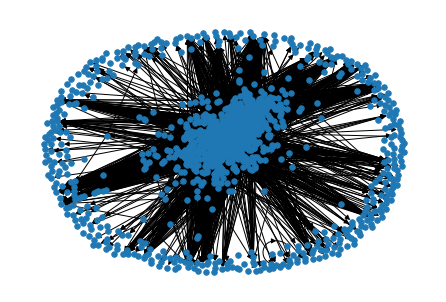

In [46]:
pos = nx.spring_layout(P)
nx.draw(P, pos, node_size=30)
plt.show()

#### Finding Communities
To perform the community detection algorithm, the **directed graph** needs to be made into an **undirected** one.

In [47]:
PR = P.to_undirected()
PR = nx.Graph(PR)

In [48]:
mypalette = ["blue", "red", "green", "yellow", "orange", "violet", "grey", "grey", "grey"]

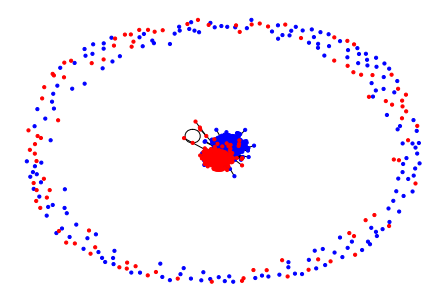

In [49]:
pos = nx.spring_layout(PR)
#colors = [mypalette[PR.node[i]['value']] for i in range(1,len(PR.nodes()))]
colors = [mypalette[PR.nodes[i]['value']] for i in PR.nodes()]
nx.draw(PR, pos, node_color=colors, node_size=10)
plt.show()

##### Extract Giant Component

In [50]:
# # returns list/set - does not work later for is_directed
# Gcc=sorted(nx.connected_components(PR), key = len, reverse=True)
# GC=list(Gcc[0])

In [51]:
Gcc = (PR.subgraph(c) for c in nx.connected_components(PR))
GC = list(Gcc)[0]

In [52]:
# # sample of blogs in GC
# for g in GC:
#     print(g)

In [53]:
partition = community.best_partition(GC)

In [54]:
print("Number of Communities: ", len(set(partition.values())))

Number of Communities:  10


In [55]:
# ensure mypalette has 11 colours
mypalette = ["blue", "red", "green", "yellow", "orange", "violet", "cyan", "purple", "brown", "pink" , "gray"]

In [56]:
for k, v in partition.items():
    GC.nodes[k]["louvain-val"] = v
colors = [mypalette[GC.nodes[node]["louvain-val"]] for node in GC.nodes()]

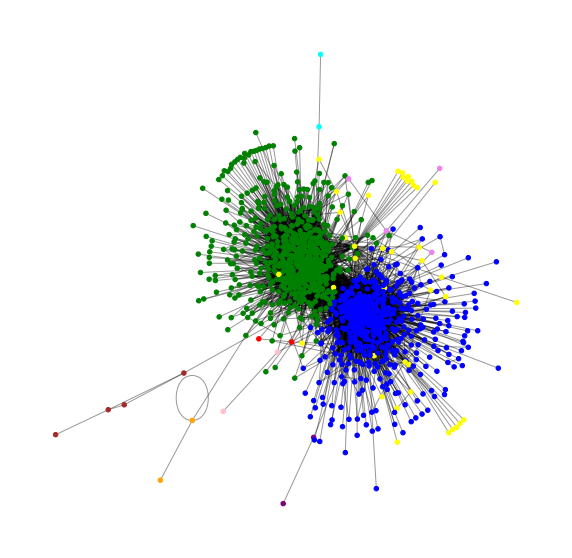

In [57]:
plt.figure(figsize=(10,10))
plt.axis('off')
pos = nx.spring_layout(GC, scale=3)
nx.draw_networkx_nodes(GC, pos, node_color=colors, node_size=20, label=True)
nx.draw_networkx_edges(GC, pos, alpha=0.4)
plt.savefig("polblogs.png")

This graph captures the community structure of political blogs and blogrolls (the list of links to other blogs frequently found in sidebars), and presents a relatively static picture of a broader blogosphere. There are a number of page links from a large set of liberal and conservative blogs, with conservative blogs linking to each other more frequently and in a denser pattern.

## Relevant References

* **Network Science** by Albert-László Barabási (2015)
* **Social Network Analysis for Startups: Finding connections on the social web** by Maksim Tsvetovat and  Alexander Kouznetsov (2011)
* **Practical Data Science Cookbook** by Tony Ojeda et al. (2014)


## Some Network Data Repositories

* [The UCI Network Data Repository](http://deim.urv.cat/~alexandre.arenas/data/welcome.htm)
* [CCNR Network Databases](http://www3.nd.edu/~networks/resources.htm)
* [Alex Arenas Website](http://deim.urv.cat/~alexandre.arenas/data/welcome.htm)
* [Stanford Large Network Dataset Collection](http://snap.stanford.edu/data/)